To use spark, set up your environment for it

In [ ]:
import os
import sys

SPARK_HOME = '...'

os.environ['SPARK_HOME'] = SPARK_HOME
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

In [ ]:
SparkAppName = 'blending'

from pyspark import SparkContext, SparkConf, HiveContext
from scipy.stats import kendalltau

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import numpy as np
import pandas as pd
from pyspark.ml.functions import array_to_vector, vector_to_array
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import PCA, PCAModel

conf = [
    ('spark.driver.memory', '10g'),
    ('spark.driver.maxResultSize', '8g'),
    ('spark.executor.cores', '3'), 
    ('spark.executor.memory', '10g'),
    ('spark.executor.memoryOverhead', '4g'),
    ('spark.sql.broadcastTimeout', 3000),
    ('spark.sql.autoBroadcastJoinThreshold', -1),
    ('spark.sql.adaptive.autoBroadcastJoinThreshold', -1),

    ('spark.shuffle.service.enabled', 'true'),
    ('spark.dynamicAllocation.enabled', 'true'),
    ('spark.dynamicAllocation.executorIdleTimeout', '120s'),
    ('spark.dynamicAllocation.cachedExecutorIdleTimeout', '600s'),
    ('spark.dynamicAllocation.initialExecutors', '1'),
    ('spark.dynamicAllocation.maxExecutors', '150'),
    ('spark.port.maxRetries', '150'),
]

spark = SparkSession.builder
for k, v in conf:
    spark = spark.config(k, v)
spark = spark.appName(SparkAppName).master("yarn").getOrCreate()
sqlc = HiveContext(spark.sparkContext)

In [ ]:
data = sqlc.read.parquet('dialog_mean_agg' + '.parquet')
sample = data.select('*').limit(1).collect()

In [ ]:
ev = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction_bcard_target', labelCol='target_1', metricName='areaUnderPR')
ev.evaluate(data)

In [ ]:
ev = BinaryClassificationEvaluator(rawPredictionCol='probability_bcard_target', labelCol='target_1')#, metricName='areaUnderPR')
ev.evaluate(data)

In [165]:
base_path = './'
target_names = ['bcard_target', 'cred_target', 'zp_target', 'acquiring_target']
id_col = 'inn'

df_cols = [*target_names, *['probability_'+target for target in target_names]]

sources = {
    'dialog': [None, 'mean_agg', 'last_agg'],
    'trx': [None, 'baseline_agg', 'baseline_gpt', 'baseline_tabformer', 'baseline'],
    'geo': [None, 'baseline_agg', 'baseline_gpt', 'baseline_tabformer', 'baseline']
}


def get_all_combs(na, nb, nc, done={(0,0,0)}):
    for i in range(na):
        for j in range(nb):
            for k in range(nc):
                if ((i,j,k) not in done) and ((j==k) or (j==0) or (k==0)):
                    yield i, j, k

                    
def get_name(a, b, c):
    dialog = sources['dialog'][a]
    trx = sources['trx'][b]
    geo = sources['geo'][c]
    name = '+'.join(['_'.join([s, x]) for s, x in zip(['dialog', 'trx', 'geo'], [dialog, trx, geo]) if x is not None])
    return name


def merge_predictions_2(a, b):
    if a is None:
        return b
    elif b is None:
        return a
    else:
        return (a + b) / 2
udf_merge_predictions_2 = F.udf(merge_predictions_2, T.FloatType())


def merge_predictions_3(a, b, c):
    k = sum([x is not None for x in (a, b, c)])
    p = sum([x for x in (a, b, c) if x is not None])
    return p / k
udf_merge_predictions_3 = F.udf(merge_predictions_3, T.FloatType())


def merge_targets_2(a, b):
    if a is None:
        return b
    elif b is None:
        return a
    else:
        return a
udf_merge_targets_2 = F.udf(merge_targets_2, T.IntegerType())


def merge_targets_3(a, b, c):
    if a is not None:
        return a
    elif b is not None:
        return b
    else:
        return c
udf_merge_targets_3 = F.udf(merge_targets_3, T.IntegerType())


def write_results(name, scores, file='results_blending.csv'):
    with open(file, 'a') as f:
        f.write(','.join([name, str(np.mean(scores)), *[str(s) for s in scores]])+'\n')


def make_blending(exp_name):
    if '+' in exp_name:
        df = None
        names = exp_name.split('+')
        n = len(names)
        f_p = udf_merge_predictions_2 if len(names) == 2 else udf_merge_predictions_3
        f_t = udf_merge_targets_2 if len(names) == 2 else udf_merge_targets_3
        for i, name in enumerate(names):
            new_df = sqlc.read.parquet(base_path + name + '.parquet')
            new_df = new_df.select(F.col(id_col), *[F.col(c).alias(c+'_'+str(i)) for c in df_cols])
            if df == None:
                df = new_df
            else:
                df = df.join(new_df, on=id_col, how='inner')
        
        for target in target_names:
            df = df.withColumn('probability_'+target, f_p(*[vector_to_array(F.col('probability_' + target + '_' + str(i))).getItem(1) for i in range(n)]))\
                   .withColumn(target, f_t(*[F.col(target + '_' + str(i)) for i in range(n)]))
    
    else:
        df = sqlc.read.parquet(base_path + exp_name + '.parquet')
        for target in target_names:
            df = df.withColumn('probability_'+target, vector_to_array(F.col('probability_' + target)).getItem(1))
    
    df = df.select(id_col, *[target for target in target_names], *['probability_'+target for target in target_names])
    return df.toPandas()

In [166]:
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve, auc, roc_auc_score, f1_score, precision_score, recall_score

In [177]:
def evaluate(df):
    metrics = dict()
    f1_list = list()
    roc_auc_list = list()
    ap_list = list()

    for target in target_names:

        y_true = df[target].values
        thresh = np.sum(y_true==1) / y_true.size
        y_pred_prob = df['probability_' + target].values
        y_pred = np.where(y_pred_prob >= thresh, 1, 0)

        ap = average_precision_score(y_true, y_pred_prob)
        f1 = f1_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred_prob)

        f1_list.append(f1)
        roc_auc_list.append(roc_auc)
        ap_list.append(ap)
        
        metrics['_'.join([target, 'ROCAUC'])] = roc_auc
        metrics['_'.join([target, 'AP'])] = ap
        metrics['_'.join([target, 'F1'])] = f1
    
    metrics['_'.join(['mean', 'ROCAUC'])] = np.mean(roc_auc_list)
    metrics['_'.join(['mean', 'AP'])] = np.mean(ap_list)
    metrics['_'.join(['mean', 'F1'])] = np.mean(f1_list)

    return metrics

In [ ]:
results_df = pd.read_csv('./results.csv', header=None, names=['model', 'roc_auc'])
#results_df = results_df.set_index('model').loc[:, ['roc_auc']]

In [ ]:
results_unimodal = results_df[~results_df.model.str.contains('+', regex=False)]
results_unimodal = results_unimodal.set_index('model').loc[:, ['roc_auc']]

In [ ]:
from tqdm import tqdm
new_df = dict()
for name in tqdm(results_unimodal.index):
    df = make_blending(name)
    metrics = evaluate(df)
    new_df[name] = metrics

In [ ]:
unimodal_private = pd.DataFrame.from_dict(new_df, orient='index')
unimodal_private = unimodal_private.sort_index()

In [182]:
unimodal_private.to_csv('unimodal_private.csv', sep='&')

In [184]:
def evaluate(df):
    metrics = dict()
    f1_list = list()
    roc_auc_list = list()
    ap_list = list()

    for target in target_names:

        y_true = df[target].values
        thresh = np.sum(y_true==1) / y_true.size
        y_pred_prob = df['probability_' + target].values
        y_pred = np.where(y_pred_prob >= thresh, 1, 0)

        ap = average_precision_score(y_true, y_pred_prob)
        f1 = f1_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred_prob)

        f1_list.append(f1)
        roc_auc_list.append(roc_auc)
        ap_list.append(ap)
        
        metrics['_'.join(['Blend', target, 'ROCAUC'])] = roc_auc
        metrics['_'.join(['Blend', target, 'AP'])] = ap
        metrics['_'.join(['Blend', target, 'F1'])] = f1
    
    metrics['_'.join(['Blend', 'mean', 'ROCAUC'])] = np.mean(roc_auc_list)
    metrics['_'.join(['Blend', 'mean', 'AP'])] = np.mean(ap_list)
    metrics['_'.join(['Blend', 'mean', 'F1'])] = np.mean(f1_list)

    return metrics

In [ ]:
results_multimodal = results_df[results_df.model.str.contains('+', regex=False)]
results_multimodal = results_multimodal.set_index('model').loc[:, ['roc_auc']]
results_multimodal

In [ ]:
new_df_2, new_df_3 = dict(), dict()
for name in tqdm(results_multimodal.index):
    df = make_blending(name)
    metrics = evaluate(df)
    metrics['Concat mean ROCAUC'] = results_multimodal.loc[name, 'roc_auc']
    
    if len(name.split('+')) == 2:
        new_df_2[name] = metrics
    else:
        new_df_3[name] = metrics

multimodal_private_2 = pd.DataFrame.from_dict(new_df_2, orient='index').sort_index()
multimodal_private_3 = pd.DataFrame.from_dict(new_df_3, orient='index').sort_index()
multimodal_private = pd.concat([multimodal_private_2, multimodal_private_3])
multimodal_private

In [187]:
multimodal_private.to_csv('multimodal_private.csv', sep='&')

# Public matching

In [ ]:
path_to_matching = 'matching_'

match_results = pd.read_csv('results_matching.csv', header=None, names=['model', 'roc_auc'])
match_results = match_results.set_index('model').loc[:, ['roc_auc']]
match_results.head()

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d


def eer(y_true, y_pred):
    fpr, tpr, thresh = roc_curve(y_true, y_pred, pos_label=1)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer


def get_metrics(df, rocauc):
    metrics = dict()
    y_true = df['target'].values
    y_pred_prob = df['probability'].values
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['EER'] = eer(y_true, y_pred_prob)
    metrics['ROCAUC'] = rocauc
    return metrics

all_metrics = dict()
for name in tqdm(match_results.index):
    data = sqlc.read.parquet(path_to_matching + name + '.parquet')
    df = data.select('target', vector_to_array(F.col('probability')).getItem(1).alias('probability')).toPandas()
    metrics = get_metrics(df, match_results.loc[name, 'roc_auc'])
    all_metrics[name] = metrics

matching_results = pd.DataFrame.from_dict(all_metrics, orient='index').sort_index()

In [196]:
matching_results.to_csv('results_matching.csv', sep='&')

# Graphs

In [ ]:
private_1 = pd.read_csv('unimodal_private.csv', sep='&').rename(columns = {'mean_ROCAUC': 'mean_ROCAUC_private'})
private_2 = pd.read_csv('multimodal_private.csv', sep='&').rename(columns = {'Concat mean ROCAUC': 'mean_ROCAUC_private'})
private = pd.concat([private_1, private_2]).loc[:, ['Unnamed: 0', 'mean_ROCAUC_private']].set_index('Unnamed: 0')
private.head()

In [ ]:
public_1 = pd.read_csv('unimodal_public.csv', sep='&').rename(columns = {'mean ROCAUC': 'mean_ROCAUC_public'})
public_2 = pd.read_csv('multimodal_public.csv', sep='&').rename(columns = {'Concat mean ROCAUC': 'mean_ROCAUC_public'})
public = pd.concat([public_1, public_2]).loc[:, ['Unnamed: 0', 'mean_ROCAUC_public']].set_index('Unnamed: 0')
public.head()

In [ ]:
pp = public.join(private, how='inner')

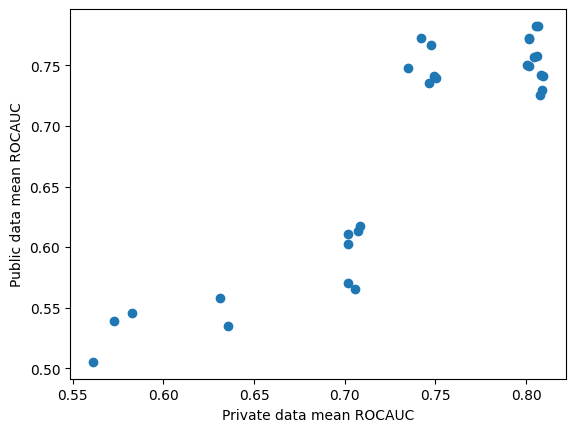

In [242]:
import matplotlib.pyplot as plt
plt.scatter(pp['mean_ROCAUC_private'].values, pp['mean_ROCAUC_public'].values)
plt.xlabel("Private data mean ROCAUC")
plt.ylabel("Public data mean ROCAUC")
plt.savefig('scatter.pdf')

In [233]:
kendalltau(pp['mean_ROCAUC_public'].values, pp['mean_ROCAUC_private'].values)

SignificanceResult(statistic=0.5665024630541872, pvalue=5.379779683462273e-06)

In [235]:
kendalltau(pp['mean_ROCAUC_private'].values, pp['mean_ROCAUC_public'].values)

SignificanceResult(statistic=0.5665024630541872, pvalue=5.379779683462273e-06)